In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar

from utils import compute_mean_square_error, formatter, FONT
from generate_inputs import RUNS, A0_VALUES, DEFAULT_TIME, DEFAULT_DT, M_VALUES

In [2]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'brown', 'pink', 'gray', 'cyan']

In [3]:
print(f"A0 values: {A0_VALUES}")
print(f"M values: {M_VALUES}")

A0 values: [np.float64(0.5), 1, np.float64(1.4), np.float64(2.3), np.float64(3.2), np.float64(4.1), np.float64(5.0)]
M values: [80, 90, 100, 110, 120]


In [4]:
def calculate_q(exits_data, steady_state, min_q=0.0, max_q=2.0):
    filtered_data = exits_data[exits_data.index > steady_state]

    x_values = filtered_data.index
    y_values = filtered_data

    x0 = x_values[0]
    y0 = y_values.iloc[0]

    fit_x_values = x_values - x0
    fit_y_values = y_values - y0

    # Define the mean square error function for a given q
    def mse_for_q(q):
        return compute_mean_square_error(q, fit_x_values, fit_y_values)

    # Use minimize_scalar to find the best q
    result = minimize_scalar(mse_for_q, bounds=(min_q, max_q), method='bounded')

    best_q = result.x
    min_error = result.fun

    return x0, y0, best_q, min_error

def calculate_q_with_errors(exits_data, steady_state, min_q=0.0, max_q=2.0, tries=100):
    filtered_data = exits_data[exits_data.index > steady_state]

    x_values = filtered_data.index
    y_values = filtered_data

    x0 = x_values[0]
    y0 = y_values.iloc[0]

    fit_x_values = x_values - x0
    fit_y_values = y_values - y0

    # Define the mean square error function for a given q
    def mse_for_q(q):
        return compute_mean_square_error(q, fit_x_values, fit_y_values)

    # Use minimize_scalar to find the best q
    result = minimize_scalar(mse_for_q, bounds=(min_q, max_q), method='bounded')
    best_q = result.x
    min_error = result.fun

    # Calculate errors for plotting
    q_values = np.linspace(min_q, max_q, tries)
    q_errors = [mse_for_q(q) for q in q_values]

    # Insert precise best_q and min_error at the correct position
    insert_idx = np.searchsorted(q_values, best_q)
    q_values = np.insert(q_values, insert_idx, best_q)
    q_errors = np.insert(q_errors, insert_idx, min_error)

    return x0, y0, best_q, min_error, q_values, q_errors

# Ejercicio B

In [5]:
time_points = [i * DEFAULT_DT for i in range(int(DEFAULT_TIME / DEFAULT_DT))]

b_q_means = np.zeros(len(A0_VALUES))
b_q_std = np.zeros(len(A0_VALUES))

for i in range(len(A0_VALUES)):

    b_q_values = np.zeros(RUNS)
    b_errors = np.zeros(RUNS)

    print(time.time(), i)

    for j in range(RUNS):
        print(j, end='\r')
        exits_file = f"../outputs/2_{i}_{j}_exits.csv"
        exits_data = pd.read_csv(exits_file)
        # print(exits_data)
        exits_data["time"] = (exits_data["time"] / DEFAULT_DT).round() * DEFAULT_DT

        crossings_count = exits_data["time"].value_counts().reindex(time_points, fill_value=0).cumsum()

        _, _, q, error = calculate_q(crossings_count, 200.0)

        b_q_values[j] = q
        b_errors[j] = error

    b_q_means[i] = np.mean(b_q_values)
    b_q_std[i] = np.std(b_q_values)

1732480808.9123685 0
1732480813.6400456 1
1732480818.273419 2
1732480822.886163 3
1732480827.4644523 4
1732480832.1462975 5
1732480837.113012 6


In [6]:
print(b_q_means)
print(b_q_std)

[0.56041911 0.69338611 0.90396094 1.08193434 1.06679074 1.16314874
 1.47434396]
[0.11814605 0.13888514 0.13532805 0.17594394 0.1869937  0.22302722
 0.1527876 ]


In [7]:
b_q_means_fit = [b_q_mean - b_q_means[0] for b_q_mean in b_q_means]
b_a0_fit = [a0 - A0_VALUES[0] for a0 in A0_VALUES]

print(b_q_means_fit)
print(b_a0_fit)

b_possible_vals = np.linspace(0.0, 1.0, 200)
errors = [compute_mean_square_error(b, b_a0_fit, b_q_means_fit) for b in b_possible_vals]

b_min_b_error_idx = np.argmin(errors)
b_min_b_error = errors[b_min_b_error_idx]
b_best_b = b_possible_vals[b_min_b_error_idx]

print(f"Best b: {b_best_b}")
print(f"Min error: {b_min_b_error}")

[np.float64(0.0), np.float64(0.13296700133633055), np.float64(0.34354182534449107), np.float64(0.5215152274365775), np.float64(0.5063716250512409), np.float64(0.6027296313772506), np.float64(0.9139248519284087)]
[np.float64(0.0), np.float64(0.5), np.float64(0.8999999999999999), np.float64(1.7999999999999998), np.float64(2.7), np.float64(3.5999999999999996), np.float64(4.5)]
Best b: 0.20100502512562815
Min error: 0.00986200833515538


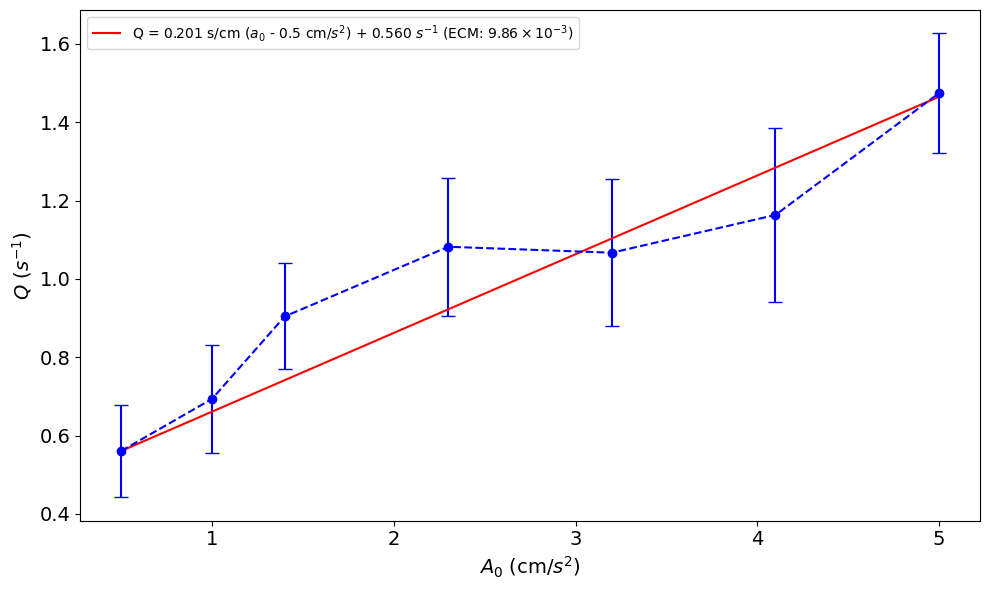

<Figure size 640x480 with 0 Axes>

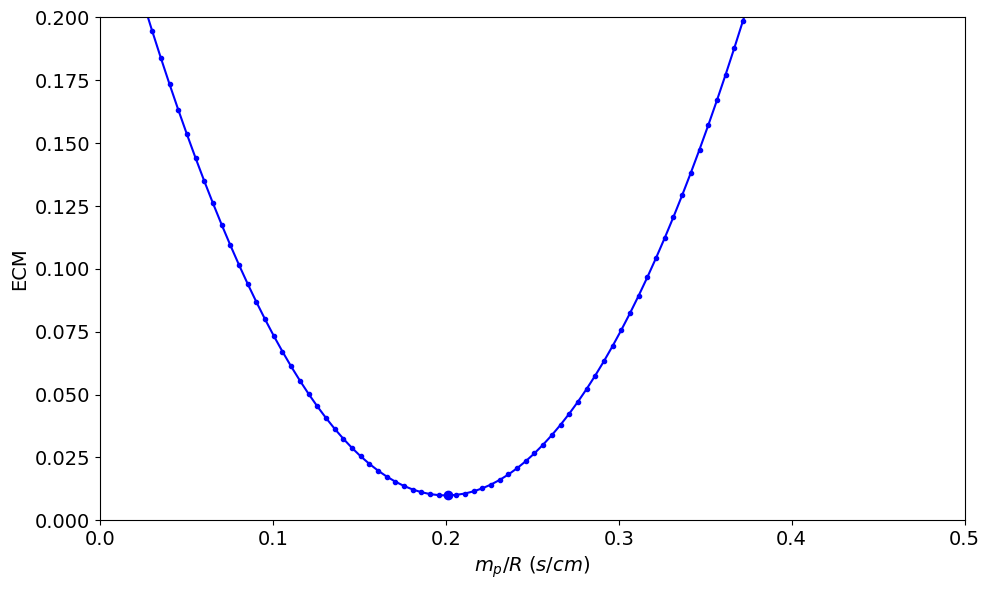

R: 4.975


<Figure size 640x480 with 0 Axes>

In [8]:
# Graph q_means vs a0 with error bars
# plt.scatter(A0_VALUES, b_q_means)
plt.figure(figsize=(10, 6))
plt.errorbar(A0_VALUES, b_q_means, yerr=b_q_std, fmt='o--', capsize=5, color=colors[0])
plt.plot(A0_VALUES, [b_best_b * (a0 - A0_VALUES[0]) + b_q_means[0] for a0 in A0_VALUES],
         label=f"Q = {b_best_b:.3f} s/cm ($a_0$ - {A0_VALUES[0]} cm/$s^2$) + {b_q_means[0]:.3f} $s^{{-1}}$ (ECM: {formatter(b_min_b_error, None)})", color=colors[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$A_0$ (cm/$s^2$)", fontdict=FONT)
plt.ylabel("$Q$ ($s^{-1}$)", fontdict=FONT)
plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig("../analysis/q_vs_a0.png", dpi=300)
plt.show()
plt.clf()

plt.figure(figsize=(10, 6))

plt.plot(b_possible_vals, errors, marker='.', color='blue')
min_idx = np.argmin(errors)
plt.plot(b_possible_vals[min_idx], errors[min_idx], 'o', color='blue')
plt.xlabel("$m_p / R$ ($s/cm$)", fontdict=FONT)
plt.ylabel("ECM", fontdict=FONT)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.0, 0.5)
plt.ylim(0, 0.2)
plt.tight_layout()
plt.savefig("../analysis/q_vs_a0_error.png", dpi=300)
plt.show()
plt.clf()

# Q = m_p * a0 / R
# b = m_p / R
# R = m_p / b

print(f"R: {1 / b_best_b}")

# Ejercicio C

In [9]:
c_q_means = np.zeros((len(M_VALUES), len(A0_VALUES)))
c_q_std = np.zeros((len(M_VALUES), len(A0_VALUES)))

for i in range(len(M_VALUES)):
    for j in range(len(A0_VALUES)):
        c_q_values = np.zeros(RUNS)
        c_errors = np.zeros(RUNS)

        for k in range(RUNS):
            print(j, end='\r')
            exits_file = f"../outputs/3_{i}_{j}_{k}_exits.csv"
            exits_data = pd.read_csv(exits_file)
            # print(exits_data)
            exits_data["time"] = (exits_data["time"] / DEFAULT_DT).round() * DEFAULT_DT

            crossings_count = exits_data["time"].value_counts().reindex(time_points, fill_value=0).cumsum()

            _, _, q, error = calculate_q(crossings_count, 200.0)

            c_q_values[k] = q
            c_errors[k] = error

        c_q_means[i][j] = np.mean(c_q_values)
        c_q_std[i][j] = np.std(c_q_values)


In [10]:
print(c_q_means)
print(c_q_std)

[[0.77441512 1.3064118  1.26476712 1.45259817 1.79354397 1.76088614
  1.99074019]
 [0.58847946 0.97160016 0.92592993 1.41462704 1.41298832 1.49263137
  1.56060794]
 [0.59647236 0.6260104  0.77406486 1.16135004 1.17092357 1.487418
  1.32389695]
 [0.48459028 0.59042454 0.81423061 0.97204714 0.91852956 1.19573969
  1.11719189]
 [0.48002153 0.44601675 0.55458011 0.62969407 0.64944191 0.96109563
  0.93897886]]
[[0.09450297 0.0720294  0.19027992 0.33733557 0.15973974 0.23407424
  0.01851161]
 [0.23676279 0.17001767 0.22251526 0.15651044 0.17143576 0.14121196
  0.38591732]
 [0.10272337 0.24343718 0.16010241 0.21566991 0.1537456  0.15371409
  0.26976726]
 [0.10787299 0.21035351 0.19941566 0.23314844 0.14220176 0.34598771
  0.2482744 ]
 [0.04249706 0.13323252 0.05009605 0.19670655 0.31290235 0.35978638
  0.18666074]]


In [11]:
c_inv_resistance = np.zeros(len(M_VALUES))
c_inv_resistance_ecm = np.zeros(len(M_VALUES))

c_inv_resistance_errors = []
c_inv_resistance_values = []

for i in range(len(M_VALUES)):
    c_q_means_fit = [c_q_mean - c_q_means[i][0] for c_q_mean in c_q_means[i]]
    c_a0_fit = [a0 - A0_VALUES[0] for a0 in A0_VALUES]


    def mse_for_c(c):
        return compute_mean_square_error(c, c_a0_fit, c_q_means_fit)

    result = minimize_scalar(mse_for_c, bounds=(0.0, 6.0), method='bounded')

    c_inv_resistance[i] = result.x
    c_inv_resistance_ecm[i] = result.fun
    
    c_inv_res_v = np.linspace(result.x - 0.2, result.x + 0.2, 100)
    c_inv_res_e = [mse_for_c(c) for c in c_inv_res_v]
    
    c_inv_min_idx = np.searchsorted(c_inv_res_v, result.x)
    c_inv_res_v = np.insert(c_inv_res_v, c_inv_min_idx, result.x)
    c_inv_res_e = np.insert(c_inv_res_e, c_inv_min_idx, result.fun)
    
    c_inv_resistance_errors.append(c_inv_res_e)
    c_inv_resistance_values.append(c_inv_res_v)


In [12]:
print(c_inv_resistance)
print(c_inv_resistance_ecm)

[0.30590292 0.26424175 0.20587534 0.17422984 0.10210091]
[0.04033736 0.03677308 0.01508438 0.01310699 0.0046961 ]


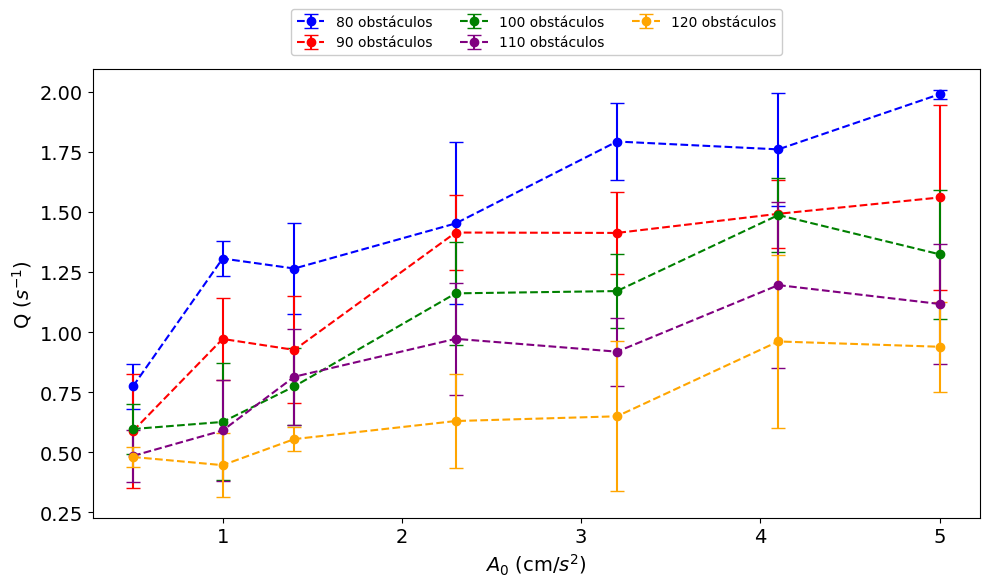

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10, 6))
for i in range(len(M_VALUES)):
    plt.errorbar(A0_VALUES, c_q_means[i], yerr=c_q_std[i], fmt='--o', capsize=5, label=f"{M_VALUES[i]} obstáculos", color=colors[i])
    # plt.plot(A0_VALUES, [c_inv_resistance[i] * (a0 - A0_VALUES[0]) + c_q_means[i][0] for a0 in A0_VALUES],
    #          label=f"y = {c_inv_resistance[i]:.3f}x (ECM: {formatter(c_inv_resistance_ecm[i],None)})",
    #          color=colors[i],)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), framealpha=1.0, ncol=3)

# plt.subplots_adjust(top=0.95)
plt.xlabel("$A_0$ (cm/$s^2$)", fontdict=FONT)
plt.ylabel("Q ($s^{-1}$)", fontdict=FONT)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("../analysis/q_vs_a0_m.png", dpi=300)
plt.show()
plt.clf()


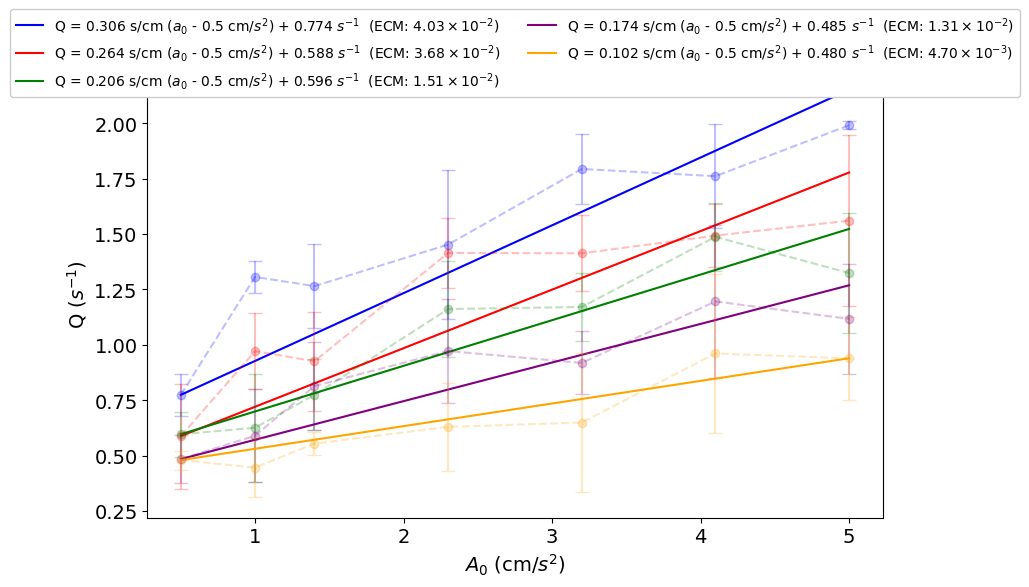

<Figure size 640x480 with 0 Axes>

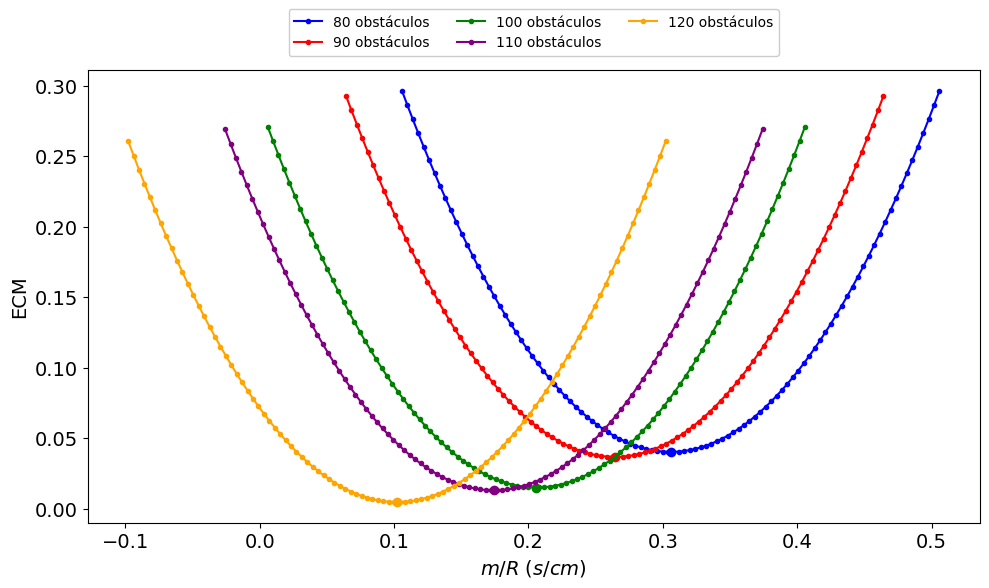

<Figure size 640x480 with 0 Axes>

In [14]:

plt.figure(figsize=(10, 6))
for i in range(len(M_VALUES)):
    plt.errorbar(A0_VALUES, c_q_means[i], yerr=c_q_std[i], fmt='--o', capsize=5, alpha=0.25, color=colors[i])
    plt.plot(A0_VALUES, [c_inv_resistance[i] * (a0 - A0_VALUES[0]) + c_q_means[i][0] for a0 in A0_VALUES],
             label=f"Q = {c_inv_resistance[i]:.3f} s/cm ($a_0$ - {A0_VALUES[0]} cm/$s^2$) + {c_q_means[i][0]:.3f} $s^{{-1}}$  (ECM: {formatter(c_inv_resistance_ecm[i],None)})",
             color=colors[i],)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), framealpha=1.0, ncol=2)

# plt.subplots_adjust(top=0.95)
plt.xlabel("$A_0$ (cm/$s^2$)", fontdict=FONT)
plt.ylabel("Q ($s^{-1}$)", fontdict=FONT)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("../analysis/q_vs_a0_m_lines.png", dpi=300)
plt.show()
plt.clf()

plt.figure(figsize=(10, 6))
for i in range(len(M_VALUES)):
    plt.plot(c_inv_resistance_values[i], c_inv_resistance_errors[i], marker='.', label=f"{M_VALUES[i]} obstáculos", color=colors[i])
    min_idx = np.argmin(c_inv_resistance_errors[i])
    plt.plot(c_inv_resistance_values[i][min_idx], c_inv_resistance_errors[i][min_idx], 'o', color=colors[i])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), framealpha=1.0, ncol=3)
plt.xlabel("$m/R$ ($s/cm$)", fontdict=FONT)
plt.ylabel("ECM", fontdict=FONT)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("../analysis/q_vs_a0_m_error.png", dpi=300)
plt.show()
plt.clf()



In [15]:
c_resistance = 1 / c_inv_resistance
c_resistance_error = 1 / (c_resistance ** 2) * c_inv_resistance_ecm
print(c_resistance)
print(c_resistance_error)

[3.26901092 3.78441332 4.85730824 5.73954491 9.79423222]
[3.77463303e-03 2.56763277e-03 6.39346134e-04 3.97876153e-04
 4.89549244e-05]


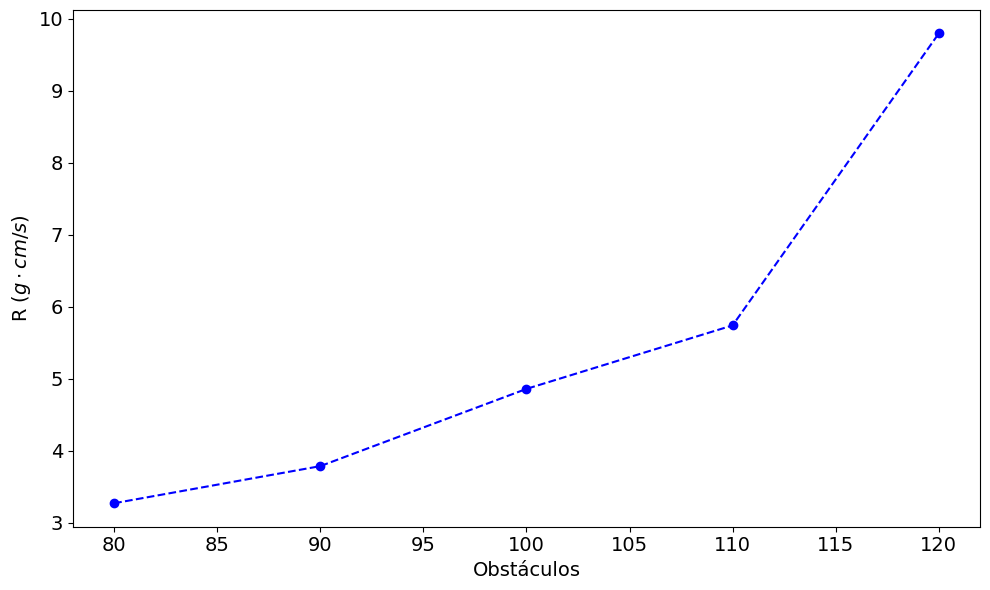

<Figure size 640x480 with 0 Axes>

In [16]:
# plt.errorbar(M_VALUES, c_resistance, yerr=c_resistance_error, fmt="o--", capsize=5 , color='blue')
plt.figure(figsize=(10, 6))
plt.plot(M_VALUES, c_resistance, "o--", color='blue')
plt.xlabel("Obstáculos", fontdict=FONT)
plt.ylabel("R ($g \\cdot cm/s$)", fontdict=FONT)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(0, 6.5)
plt.tight_layout()

plt.savefig("../analysis/resistance_vs_m.png", dpi=300)
plt.show()
plt.clf()